# Part 5: Grouping Data Science Skills & Experience

Data science is a broad term used to cover many different roles. The knowledge, skills and experience that a data scientist needs will depend on the sector and type of organisation they are working in, and the product or goal of the organisation. 

I have completed 31 data science courses and my own projects using these skills, but now I want to see how my knowldge and experience matches up with vast array of data science skills and tools out there.

> "Are there skills and tools that tend to be mentioned with those that I have knowledge and experience of, which I should learn ahead of applying for jobs? 

I also know of a lot of different data science skills and tools that I do not yet have experience with.

> "How do the different data science skills and tools I've heard of fit together in terms of how they're most often used together by organisations?"

**To answer these I need to figure out which data science skills and tools that tend to be mentioned together in job descriptions.**

## Setup

### Import Packages & Modules

In [2]:
# import packages and modules
import pandas as pd 
import pickle
import numpy as np 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import random
import scipy.stats as stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
import itertools
from sklearn.metrics import matthews_corrcoef
import plotly.express as px
import plotly.io as pio



### Display Settings

In [3]:
# ensure all columns and rows will be displayed if/when you print the dataframe
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# ensure all figures will have a white background in this notebook
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

# to ensure plotly express works in the vscode notebook
pio.renderers.default = "notebook"

### Import Data & Dictionaries

In [4]:
# provide the path to the location of the cleaned scraped glassdoor job data
path = './data/'

# provide glassdoor scrape date
scrapedate = '14Dec2020'  # e.g. '14Dec2020', '16Feb2021'

# create the absolute path to the wrangled data scientist job data
filename = os.path.join(path, f"dsjobs_df_{scrapedate}_wrangled.pkl")

# read the cleaned data scientist jobs data (.pkl file) into a dataframe
dsjobs = pd.read_pickle(filename)

# display dataframe info to check that it's what you expected
dsjobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Columns: 155 entries, job_title to degree_any
dtypes: Int64(1), bool(130), category(7), float64(8), object(9)
memory usage: 141.8+ KB


Previously, in the wrangling chapter of this project, I created and used nested dictionaries (`dict_skills` and `dict_tools`) to search the description text of each job for a wide range of data science skills and tools.

The skills and tools searched for were chosen based on:
1. my own knowledge of various data scientist roles, 
2. scanning many of the job descriptions in the data set, and 
3. additional web searches

I will require the same dictionaries here to analyse the strength of association between skills and tools and to visualise the results.


In [5]:
# import the necessary dictionaries from .pkl file
with open('dsjobs_dicts.pkl', 'rb') as f:
    gdjobs_dicts = pickle.load(f)

# print dictionaries in gdjobs_dicts
print(gdjobs_dicts.keys())


dict_keys(['dict_skills', 'dict_tools', 'dict_degsubjects', 'dict_qualifications'])


`dict_skills` and `dict_tools` contain nested dictionaries for each skill/tool with the following keys:
- `'re'`: the regular expression used to search the job description text,
- `'label'`: a readable text label for the skill/tool to be used in plots

In [6]:
# print 3 random key-value pairs from dict_skills
random.sample(list(gdjobs_dicts['dict_skills'].items()), 3)

[('distributed_data', {'re': 'distributed data', 'label': 'Distributed Data'}),
 ('NLP',
  {'re': 'natural language processing|NLP',
   'label': 'Natural Language Processing'}),
 ('data_mining', {'re': '\\bmine\\b|\\bmining\\b', 'label': 'Data Mining'})]

The results of the job description text analysis, which searched for mentions of the skills/tools, were added to the data scientist jobs dataframe, `ds`, as a boolean mask (column) for each one. The headers used for these columns are the same as the keys of the `dict_skills` and `dict_tools` dictionaries.

## Measuring strength of association between data science skills and tools

I need a way to measure similarity between skills/tools in terms of how often they are mentioned together, using the boolean columns that record the result of the text search for each. 

**There are two methods commonly used to infer association between two categorical variables**:

1. **Statistical metrics** use contingency tables, which display the multivariate frequency distribution of the categorical variables (see example, below), to calculate strength of association between them. Several use the chi-squared statistic, e.g. Phi Co-efficient, Cramer's V, and Contingency coefficient C, to calculate 'goodness of fit' and test statistical hypotheses. 

2. **Distance metrics**, used to calculate the proximity of data points based on their distance in multi-dimensional space, are often used as a proxy for correlation between categorical variables. Distance metrics are used in both supervised and unsupervised machine learning algorithms. They are not easily comparable between variable pairs that have a different number of categories.  


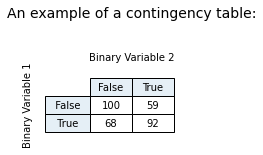

In [7]:
# create dummy data for contingency table
data = [[100,59],[68,92]]

# turn dummy data into text for the figure
cell_text = []
for row in data:
    cell_text.append([f'{x}' for x in row])

# create figure
fig, ax = plt.subplots(1,1, figsize=(3,1.5))
ax.set_ylabel("Binary Variable 1", fontsize=10, labelpad=15)
ax.set_xlabel("Binary Variable 2", fontsize=10)    
ax.xaxis.set_label_position('top') 
ax.set_title("An example of a contingency table:", fontsize=14, y=1.5)
plt.box(on=None)
plt.xticks([])
plt.yticks([])
row_headers = ["  False  ","  True  "]
column_headers = ["False","True"]
rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

# plot table and scale
the_table = plt.table(cellText=cell_text, 
    rowLabels=row_headers, 
    rowColours=rcolors, 
    rowLoc='center', 
    colLoc='center', 
    cellLoc='center', 
    colWidths=[0.25,0.25], 
    colColours=ccolors, 
    colLabels=column_headers, 
    loc='center'
)
the_table.scale(1, 1.5)

plt.show()

Since our variables (the presence/absence of skills/tools in the job description) are binary, with True (1/presence) or False (0/absence) being the only values, they are all on the same scale. We also want to use unsupervised clustering (hierarchical clustering) to identify groups of skills and tools; so, it is acceptable and appropriate to use a distance metric as a proxy for association between skills and tools in our data set.

### Selecting skills/tools to be included

I'm not interested in skills/tools only mentioned in very few job descriptions; so, I will set an arbitrary baseline level (the minimum % of job descriptions that should mention a skill/tool to be included: **3%** 

I will use this lower limit to exclude uncommon skills and tools from the correlation analysis.

In [8]:
# combine the skills and tools dictionaries 
dict_both_st = gdjobs_dicts['dict_skills'] | gdjobs_dicts['dict_tools']

In [9]:
# get a list of all skills and tools searched for 
both_st_li = list(dict_both_st.keys())

# calculate the % job descriptions mentioning each skill/tool in our list
st_pct = dsjobs.loc[:,both_st_li].mean(axis=0)
st_pct = round(st_pct*100,1)

# create a series of skills/tools found in at least 3% of jobs & their prevalence
st_inc_pct = st_pct[st_pct >= 3.0]

# # print the prevalence of skills and tools found in >=3% jobs
# print(st_inc_pct.sort_values(ascending=False))

# create a DataFrame of the skills/tools text analysis results
# with columns in descending order of prevalence
ds_bothst = dsjobs.loc[:,st_inc_pct.sort_values(ascending=False).index]


### Strength of association using a statistical metric

The **Phi coefficient** is a statistical measure of association for two binary variables, specifically designed for a 2x2 contingency table. If we have a 2×2 table for two random variables x and y,

<img src="./images/phi_example.png" style="display:block; margin:auto"/>

then, then the formula for phi is:

$$ \phi = \frac{n_{11}n_{00} - n_{10}n_{01}}{\sqrt{n_{1\bullet}n_{0\bullet}n_{\bullet0}n_{\bullet1}}} $$

Two binary variables are considered positively associated if most of the data falls along the diagonal cells. In contrast, two binary variables are considered negatively associated if most of the data falls off the diagonal. 

In machine learning, the Matthews correlation coefficient (MCC), which is the equivalent of Phi, is used as a measure of the quality of binary and multi-class classifications.

Phi/MCC are similar to the Pearson correlation coefficient (the commonly used measure of linear correlation between two continuous vartiables). In fact, the Pearson correlation coefficient for two binary variables is the same as Phi/MCC. ([reference](https://en.wikipedia.org/wiki/Phi_coefficient)). I will illustrate this with dummy binary data:


In [10]:
# dummy data
dummy_a = [1,1,1,1,1,1,1,1,0,0,0,0]
dummy_b = [0,0,1,1,1,1,1,1,0,0,0,1]

# calculate MCC (Phi) coefficient for the dummy variables 
print(f"MCC/Phi:\t{matthews_corrcoef(y_true=dummy_a, y_pred=dummy_b)}")

# calculate Pearson's correlation coefficient for the dummy variables
print(f"Pearson's r:\t{stats.pearsonr(dummy_a,dummy_b)[0]}")


MCC/Phi:	0.47809144373375745
Pearson's r:	0.47809144373375745


#### A Phi/MCC/Pearson's r correlation matrix of data science skills/tools

I will create and visualise a Phi/MCC/Pearson's *r* correlation matrix for the skills/tools job description text analysis results

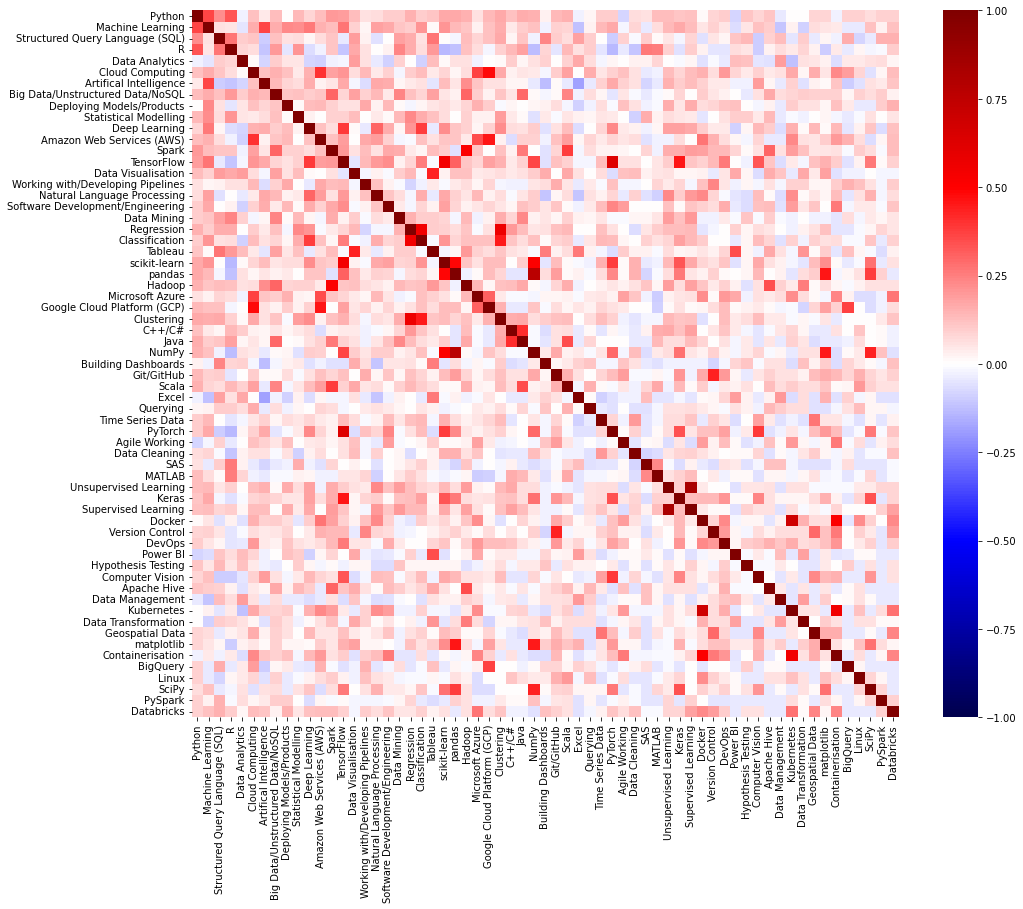

In [11]:
# create a phi/mcc correlation matrix of the skills/tools text analysis results
phiMatrix_st = round(ds_bothst.corr(),2)
for column in phiMatrix_st:
    phiMatrix_st.rename(columns={column:dict_both_st[column]['label']}, index={column:dict_both_st[column]['label']}, inplace=True)

# plot a heatmap of the correlation matrix
fig = plt.figure(figsize=(16,13))
sns.heatmap(
    phiMatrix_st, 
    annot=False,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    square = True
    )
plt.show()


The order of the skills and tools in the heatmap of Pearson's *r*, above, is by their prevalance (the % of job descriptions they are mentioned in), **not on any clustering algorithm**. The correlation coefficients between commonly mentioned skills/tools are similar to the correlation coefficients of skills/tools that are rarely mentioned.

In [12]:
# turn the Phi/MCC/Pearson's r matrix into a vector for box plot
# turn the df into a numpy array
phiMatrix_st = phiMatrix_st.to_numpy()

# switch the diagonal values from 1 to 0 for compatability with distance.squareform
np.fill_diagonal(phiMatrix_st,0)

# force the square phiMatrix_st into a vector
phiVector_st = distance.squareform(phiMatrix_st, force='tovector')

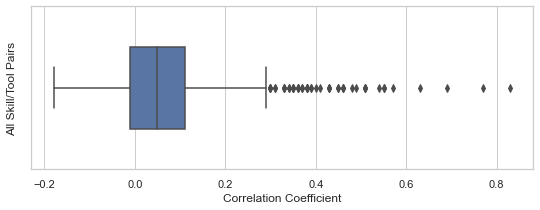

In [13]:
# box plot of skill/tool correlation coefficients 
fig = plt.figure(figsize=(9, 3))
sns.set_theme(style="whitegrid")
fig = sns.boxplot(x=phiVector_st, width=0.5)
plt.xlabel("Correlation Coefficient")
plt.ylabel("All Skill/Tool Pairs")
plt.show()

The heatmap and boxplot of the Pearson's r/Phi/MCC correlation matrix (above) indicate most pairs of skills/tools have a have a weak positive or negative relationship.

I will take a closer look at the correlation data to see if skill/tool pairs of different frequencies and high/low correlation coefficients make sense.


#### A closer look at the correlation coefficients

I will pick out some of these skill/tool pairs and take a closer look at the numbers with a 2 x 2 contingency table, and a scatter plot of the data. I will use a linear regression plot to show the correlation because the slope of a first degree (linear) polynomial ($a$ in $y = ax + b$) is the same as $r$ when $y$ and $x$ are normalized to one another using their standard deviations ($\delta$). 

$$ r_{x,y} = a\frac{\delta_{x}}{\delta_{y}} $$

To avoid repeating the code, I will create a function for this purpose: `correlatebinvar` 

In [14]:
def correlatebinvar(df, var1, var2, table=True, plot=True):
    """
    This function takes a pandas DataFrame and two boolean variables as two column labels
    It prints the 2 column labels, and the proportion of 'True' cells in the column for each variable
    It uses pandas.Series.corr to produce the Pearson's correlation coefficent of the two variables, and prints it
    If 'table`is True (default), a 2 x 2 contingency table of the data will be produced
    If `plot` is True (default), a scatter plot of data and a line showing the Pearson's Correlation Coefficient will be given
        A linear regression plot is used to show the correlation because the slope of a first degree (linear) polynomial (a in y = ax + b) is the
        same as r when y and x are normalized to one another using their standard deviations (delta):
        r(x,y) = a(delta(x)/delta(y))
    """
    print(f"*** {dict_both_st[var1]['label']} vs {dict_both_st[var2]['label']} ***\n")
    print(f"Jobs mentioning {dict_both_st[var1]['label']}: {round(df[var1].mean()*100,1)}%")
    print(f"Jobs mentioning {dict_both_st[var2]['label']}: {round(df[var2].mean()*100,1)}%\n")


    count_11, count_10, count_01, count_00 = 0, 0, 0, 0

    for index, row in df.iterrows():
        if ((row[var1] == True) & (row[var2] == True)):
            count_11 += 1
        elif ((row[var1] == True) & (row[var2] == False)):
            count_10 += 1
        elif ((row[var1] == False) & (row[var2] == True)):
            count_01 += 1
        elif ((row[var1] == False) & (row[var2] == False)):
            count_00 += 1

    if table:
        data = [[count_00,count_01],[count_10,count_11]]
        cell_text = []
        for row in data:
            cell_text.append([f'{x}' for x in row])
        fig, ax = plt.subplots(1,1, figsize=(4,2))
        ax.set_ylabel(dict_both_st[var1]['label'], fontsize=12, labelpad=15)
        ax.set_title(dict_both_st[var2]['label'], fontsize=12)
        plt.box(on=None)
        plt.xticks([])
        plt.yticks([])
        row_headers = ["  False  ","  True  "]
        column_headers = ["False","True"]
        rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
        ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
        the_table = plt.table(  
            cellText=cell_text,
            rowLabels=row_headers,
            rowColours=rcolors,
            rowLoc='center',
            colLoc='center',
            cellLoc='center',
            colWidths=[0.25,0.25],
            colColours=ccolors,
            colLabels=column_headers,
            loc='center',
        )
        the_table.scale(1, 1.5)
        print("Contingency table:")
        plt.show()
        
    if plot:
        r = round(df[var1].corr(df[var2]),2)
        print(f"\n")
        # calculate linear regression equation
        reg = np.polyfit(df[var1], df[var2], 1) # this gives you the slope ('a') and y intercept('b'), as a list
        #plot the data, where x and y are the boolean vectors for the mention of var 1 and var2 in the job descriptions, respectively 
        fig, ax = plt.subplots(1,1, figsize=(5, 5))
        sns.stripplot(x=var1, y=var2, data=df, jitter=True, color='black')
        # plot the Pearson's correlation coefficient using the slope of the linear regression question
        x = np.array([0,0.5,1])
        y = x * (reg[0] * np.std(df[var1])/np.std(df[var2])) + reg[1]
        plt.xticks([0,1])
        plt.yticks([0,1])
        ax.set_xlabel(dict_both_st[var1]['label'], fontsize=12)
        ax.set_xticklabels(['False', 'True'])
        ax.set_ylabel(dict_both_st[var2]['label'], fontsize=12)
        ax.set_yticklabels(['False', 'True'])  
        plt.plot(x,y, color='b')
        # apply data labels
        ax.annotate(str(count_11), (1,1), textcoords='offset points',  xytext=(0,-15), ha='center')
        ax.annotate(str(count_01), (0,1), textcoords='offset points',  xytext=(0,-15), ha='center')
        ax.annotate(str(count_10), (1,0), textcoords='offset points',  xytext=(0,7.5), ha='center')
        ax.annotate(str(count_00), (0,0), textcoords='offset points',  xytext=(0,7.5), ha='center')
        y_athalf = 0.5 * (reg[0] * np.std(df[var1])/np.std(df[var2])) + reg[1]
        ax.annotate(f"r = {str(r)}", (0.5,y_athalf), textcoords='offset points',  xytext=(0,5+20*r), ha='center', color='b')
        print(f"Scatterplot with Linear Fit Line (Pearson's r = {r}):")
        plt.show()


##### i. Two common skills/tools, moderate positive correlation

*** Python vs Machine Learning ***

Jobs mentioning Python: 81.0%
Jobs mentioning Machine Learning: 70.1%

Contingency table:


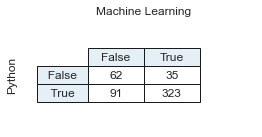



Scatterplot with Linear Fit Line (Pearson's r = 0.36):


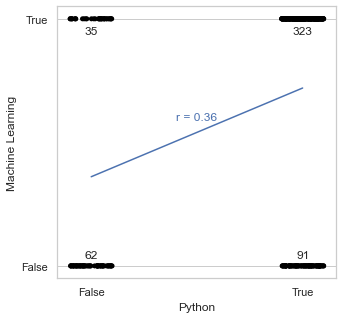

In [15]:
# high frequency, moderate positive relationship
correlatebinvar(ds_bothst, 'python', 'machine_learning')


*** Python vs Machine Learning *** : 323 jobs mention them together, but over 126 jobs mention only one or the other (roughly a 3:1 ratio), resulting in a moderate positive relationship

##### ii. Two rare skills/tools, very strong positive correlation

*** Supervised Learning vs Unsupervised Learning ***

Jobs mentioning Supervised Learning: 6.1%
Jobs mentioning Unsupervised Learning: 6.5%

Contingency table:


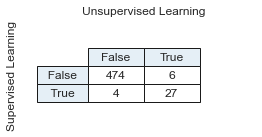



Scatterplot with Linear Fit Line (Pearson's r = 0.83):


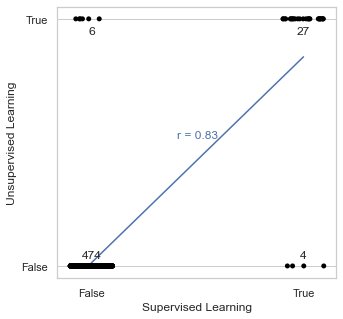

In [16]:
# low frequency, very strong positive correlation
correlatebinvar(ds_bothst, 'supervised_learning', 'unsupervised_learning')

*** Supervised Learning vs Unsupervised Learning ***: There is a similar ratio of jobs mentioning both to jobs mentioning just one or the other, as there is for python vs machine learning (about 3:1), but because almost all jobs mention neither, the correlation coefficient is suggestive of a stronger relationship between supervised and unsupervised learning than between python and machine learning

##### iii. Two common skills/tools, negligible negative correlation

*** R vs Artifical Intelligence ***

Jobs mentioning R: 44.2%
Jobs mentioning Artifical Intelligence: 30.9%

Contingency table:


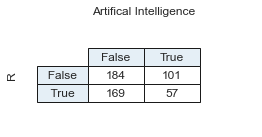



Scatterplot with Linear Fit Line (Pearson's r = -0.11):


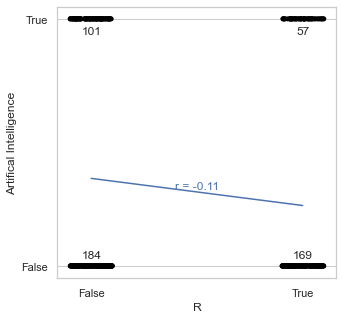

In [17]:
# high freq, negligible negative correlation
correlatebinvar(ds_bothst, 'r', 'ai')

*** R vs Artifical Intelligence ***: Five times as many jobs mention either the R programming language or AI than jobs that mention both, so there is a strong negative association. However, because there are almost just as many jobs that mention neither, the correlation coefficient only suggests a negligible negative correlation.

##### iv. Two rare skills/tools, no correlation

*** BigQuery vs Linux ***

Jobs mentioning BigQuery: 3.5%
Jobs mentioning Linux: 3.5%

Contingency table:


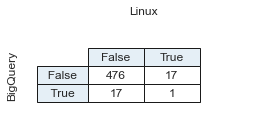



Scatterplot with Linear Fit Line (Pearson's r = 0.02):


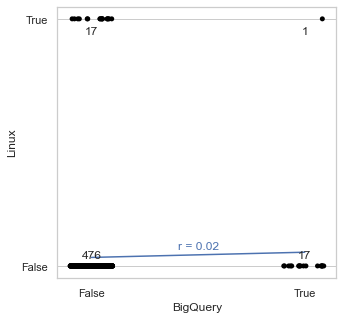

In [18]:
# low freq, no correlation
correlatebinvar(ds_bothst, 'bigquery', 'linux')

*** Linux vs BigQuery ***: These tools are almost always mentioned separately, but the hundreds of jobs that mention neither means that the correlation coeffient indicates no relationship rather than a negative correlation

#### Summary: using a statistical correlation metric to measure strength of association between skills/tools

- There are high proportion of jobs that are False for both skills/tools being compared
- Phi/MCC/Pearson's r gives the False-False values the same weight as the True-True, True-False and False-True values, 
- The vast majority of skills and tools have a negligible correlation coefficient, which would make it hard to group them using clustering

### Strength of association using a distance metric

Statistical metrics do not seem ideal for our data, so what about using a distance metric? Since our variables (the presence/absence of skills and tools in the job description) are binary, with False (0/absence) and True (1/presence) being the only values, they are all on the same scale. We also want to use unsupervised clustering (hierarchical clustering) to identify groups of skills and tools. So, it would be acceptable and appropriate for us to use a distance metric as a proxy for association between skills and tools in our data set.

#### Which distance metric?

Our data are binary (boolean) vectors , denoting the presence or absence of a skill or tool within a job description. There are many ways of calculating distance between binary vectors, but we need one that works for our data in particular:

- Our variables are asymmetric: a job description mentioning a skill/tool in most cases means it is required/desired for the role, but a lack of mention does not necessariliy mean the opposite.

- Our variables are uneqully saturated: some job descriptions will be more detailed than others.

With both the considerations above and [this Cross Validated (Stack Exchange) answer](https://stats.stackexchange.com/questions/61705/similarity-coefficients-for-binary-data-why-choose-jaccard-over-russell-and-rao/61910#61910) in mind, I will consider a few proximity measures for binary data, which I will describe in terms of two sets (or vectors of attributes), $A$ and $B$, where $|A|$ and $|B|$ are the cardinalities of the two sets (i.e. the number of attributes in each set). 

*Note that for all three metrics described below, to get the distance between sets (as is usually needed for clustering algorithms) rather than the similarity, the value of the similarity index is simply subtracted from 1, so this is how the equations for the metric are written.* 

- **Jaccard Distance**: 

$$1 - \frac{|A \ \cap\ B|}{|A \ \cup\ B|} $$

The number of matches (the intersection) divided by the combined number of attributes both sets have (the union), i.e. the probability that if either set has an attribute then both of them have it. Jaccard excludes negative matches (joint absences) from consideration, which is good because our data are sparse. However, the Jaccard index gives equal weight to positive matches (both sets having an attribute) and non-matches (only one of the 2 sets having an attribute). Given that $|A|$ and $|B|$ could be quite different, depending on how detailed the job descriptions are, it would be better to have a proximity measure that adjusts for this, by giving more weight to positive matches than non-matches. 

- **Dice Distance**: 

$$1 - \frac{2|A \ \cap\ B|}{|A| + |B|} $$

Positive matches are given double the weight and then divided by the the sum of attributes both sets have (compared the Jaccard, in which the denominator counts the attributes that match only once), but the difference in the number of attributes that the two sets have ($|A|$ vs $|B|$) is not adjusted for. Negative matches (joint absences) are excluded from consideration.


- **Ochiai Distance**: 

$$1 - \sqrt{ \left( \frac{|A \ \cap\ B|}{|A|} \cdot \frac{|A \ \cap\ B|}{|B|} \right) } $$ 

Also known as cosine distance, this is the geometric mean of the probability that if one set has an attribute, the other set has it too. Ochiai excludes negative matches (joint absences), and unlike Jaccard and Dice, it does not pool the attributes that the two sets have. Taking the geometric mean of the probability curbs the distance where the two sets are unequal: this means that the Ochiai distance between a vague job description and a detailed one - where the vague one shares all of the skills/tools it mentions with the detailed one - will be less than the Jaccard and Dice distances.

##### A comparison of distance metrics on test "dummy" data

 I'll illustrate the differences between Jaccard, Dice and Ochiai using some "dummy" data: 2 binary vectors/sets ($A$ and $B$) with 12 variables. I will look at how the distance (1 minus the similarity index) changes when:

- the number of matches increases from 1 to 8, between 2 sets with 4 differences,
- the number of differences decreases from 8 to 1, between 2 sets with 4 matches,
- and the ratio of attributes changes from 1:1 to 3:1, between 2 sets with 3 matches and 6 differences.



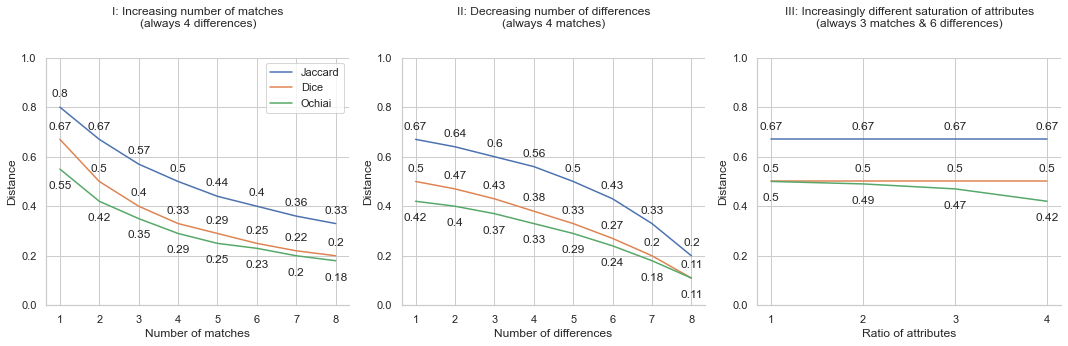

In [19]:
pair_11 = [(1,1)]
pair_10 = [(1,0)]
pair_01 = [(0,1)]
pair_00 = [(0,0)]

modeldict = {}

### Increasing number of matches from 1 to 8, between 2 sets of 12 with 4 differences ###

    # sets A and B will start as:   A: [0,0,0,0,0,0,0,0,0,0,0,1], attributes (n) = 1
    #                               B: [1,1,1,1,0,0,0,0,0,0,0,1], attributes (n) = 5

    # sets A and B will end as:     A: [0,0,0,0,1,1,1,1,1,1,1,1], attributes (n) = 8
    #                               B: [1,1,1,1,1,1,1,1,1,1,1,1], attributes (n) = 12

# increase matches between A and B from 1 to 8 and get the jaccard, dice & cosine between them

jaccard_ls = []
dice_ls = []
cosine_ls = []

for i in range(8):
    diff = 4
    if i == 0:
        null = 7
        match = 1
    else:
        null -= 1
        match += 1
    pairs = (
        pair_01*diff+
        pair_00*null+
        pair_11*match)
    set_A, set_B = zip(*pairs)
    jaccard_ls.append(round(distance.jaccard(list(set_A), list(set_B)),2))
    dice_ls.append(round(distance.dice(list(set_A), list(set_B)),2))
    cosine_ls.append(round(distance.cosine(list(set_A), list(set_B)),2))

modeldict[0] = {
    'x' : np.arange(1,9),
    'Jx' : np.array(jaccard_ls),
    'Dx' : np.array(dice_ls),
    'Cx' : np.array(cosine_ls),
    'title' : "I: Increasing number of matches\n(always 4 differences)",
    'xlabel' : "Number of matches",
    'xticklabels' : np.arange(1,9)
}

### Decreasing number of differences from 8 to 1, between 2 sets with 4 matches ###
# (without increasing matches)

    # sets A and B will start as:   A: [1,1,1,1,1,1,1,1,1,1,1,1], attributes (n) = 12
    #                               B: [0,0,0,0,0,0,0,0,1,1,1,1], attributes (n) = 4

    # sets A and B will end as:     A: [1,0,0,0,0,0,0,0,1,1,1,1], attributes (n) = 5
    #                               B: [0,0,0,0,0,0,0,0,1,1,1,1], attributes (n) = 4

# decrease differences between A and B from 8 to 1 and get jaccard, dice & cosine between them
jaccard_ls = []
dice_ls = []
cosine_ls = []

for i in range(8):
    match = 4
    if i == 0:
        null = 0
        diff = 8
    else:
        null += 1
        diff -= 1
    pairs = (
        pair_01*diff+
        pair_00*null+
        pair_11*match)
    set_A, set_B = zip(*pairs)
    jaccard_ls.append(round(distance.jaccard(list(set_A), list(set_B)),2))
    dice_ls.append(round(distance.dice(list(set_A), list(set_B)),2))
    cosine_ls.append(round(distance.cosine(list(set_A), list(set_B)),2))

modeldict[1] = {
    'x' : np.arange(1,9),
    'Jx' : np.array(jaccard_ls),
    'Dx' : np.array(dice_ls),
    'Cx' : np.array(cosine_ls),
    'title' : "II: Decreasing number of differences\n(always 4 matches)",
    'xlabel' : "Number of differences",
    'xticklabels' : ['8','7','6','5','4','3','2','1']
}

### Differing the saturation of attributes in set A vs set B ###

    # the number of matches and differences will be kept the same,
    # but there will be an increasingly different saturation of attributes, 
    # starting from equality (6v6) to icreasingly imbalanced (9v3)

    # sets A and B will start as:   A: [1,1,1,1,1,1,0,0,0,0,0,0], attributes (n) = 6
    #                               B: [1,1,1,0,0,0,0,0,0,1,1,1], attributes (n) = 6

    # sets A and B will end as:     A: [1,1,1,1,1,1,1,1,1,0,0,0], attributes (n) = 9
    #                               B: [1,1,1,0,0,0,0,0,0,0,0,0], attributes (n) = 3

jaccard_ls = []
dice_ls = []
cosine_ls = []

for i in range(4):
    match = 3
    null = 3
    if i == 0:
        aonly = 3
        bonly = 3
    else:
        aonly += 1
        bonly -= 1
    pairs = (
        pair_11*match+
        pair_10*aonly+
        pair_01*bonly+
        pair_00*null)
    set_A, set_B = zip(*pairs)
    jaccard_ls.append(round(distance.jaccard(list(set_A), list(set_B)),2))
    dice_ls.append(round(distance.dice(list(set_A), list(set_B)),2))
    cosine_ls.append(round(distance.cosine(list(set_A), list(set_B)),2))

modeldict[2] = {
    'x' : np.arange(1,5) ,
    'Jx' : np.array(jaccard_ls),
    'Dx' : np.array(dice_ls),
    'Cx' : np.array(cosine_ls),
    'title' : "III: Increasingly different saturation of attributes\n(always 3 matches & 6 differences)",
    'xlabel' : "Ratio of attributes",
    'xticklabels' : ['1:1','7:5','2:1','3:1']
}

# plot jaccard, dice and ochiai (cosine) indices for the 3 data models
fig, ax = plt.subplots(1,3, figsize=(15,5))
for axis in range(3):
    x = modeldict[axis]['x']
    ax[axis].set_title(modeldict[axis]['title'],y=1.1) 
    ax[axis].set_xlabel(modeldict[axis]['xlabel']) 
    ax[axis].set_ylabel("Distance")
    ax[axis].set_ylim(0,1)
    ax[axis].plot(x,modeldict[axis]['Jx'])
    ax[axis].plot(x,modeldict[axis]['Dx']) 
    ax[axis].plot(x,modeldict[axis]['Cx'])
    ax[axis].spines['right'].set_visible(False)
    ax[axis].spines['top'].set_visible(False)

    metrics = [
        (modeldict[axis]['Jx'],0.04),
        (modeldict[axis]['Dx'],0.04),
        (modeldict[axis]['Cx'],-0.08)
    ]

    for m in metrics:
        # x=x
        y=list(m[0])
        for i, j in zip(x,y):
            label=str(j)
            ax[axis].annotate(xy=(i,j+m[1]), text=label,ha='center')

    ax[axis].set_xticks(x)

    if axis == 0:
        ax[axis].legend(['Jaccard','Dice','Ochiai'])

fig.tight_layout()
plt.show()

**I: Increasing number of matches:** The number of positive matches between $A$ and $B$ (where, initially, $|A|=5$ and $|B|=1$) were increased from 1 to 8, one at a time, while keeping 4 differences, by adding one matched attribute to both sets, until $|A|=12$ and $|B|=8$. Note, this means that the sum of attributes ($|A|+|B|$) also increased by 2 with each step - from 6 to 20. As you'd expect, the distance between these 2 sets reduced as the number of matches increased. Dice distance reduced more quickly than both the Jaccard and Ochiai distances, since Dice gives matches double the weight of differences. The base Ochiai distance is less than Jaccard and Dice because all of $B$'s attributes are always matched by $A$, and only Ochiai factors in the number of attributes in each set independently.

**II: Decreasing number of differences:** The number of differences between $A$ and $B$ (where $|A|=12$ and $|B|=4$, with 4 positive matches), were reduced from 8 to 1 by removing attributes from $A$ one-by-one (taking the sum of attributes down from 12 to 5). The drop in the number of differences reduced the distance between $A$ and $B$ by all 3 measures. The Jaccard distance fell more quickly than the other two measures: Jaccard tells you more about the number of differences between sets than Dice and Ochiai do, which were less affected by the drop in differences. Again, the base Ochiai distance is less than Jaccard and Dice because all of $B$'s attributes are always matched by $A$.

**III: Increasing the difference in saturation of attributes:** The ratio of attributes between $A$ and $B$ (where, initially, $|A|=6$ and $|B|=6$) was changed from 1:1 to 3:1, while maintaining the same number of matches (3) and differences (6) at each stage by both increasing $|A|$ and reducing $|B|$ by 1 at each stage. Out of the 3 distance measures, only Ochiai factors in the saturation of attributes in each set, so it was the only one to change in this scenario: as $A$ and $B$ became more unequal, although the sum of attributes remained the same, the Ochiai distance reduced, because every time an attribute was dropped from $B$, a higher proportion of $B$'s attributes matched $A$'s, until all of $B$'s attributes were also present in $A$.  

##### A comparison of distance metrics on my skills/tools data

Now I will plot heatmaps to visually compare the Jaccard, Dice and Ochiai distance matrixes of the skills/tools text analysis results

In [20]:
# check the shape of the skills and tools dataframe
ds_bothst.shape

(511, 63)

The columns in the `ds_bothst` DataFrame are the skills and tools, and the rows are the jobs. To create a distance matrix for the skills/tools we need to transpose the DataFrame to make them the rows.

In [21]:
# Transpose the ds_bothst Dataframe and assign it to the variable, X
X = ds_bothst.T

# Check that the shape of the DataFrame indicates that it has been transposed:
X.shape

(63, 511)

The `scipy.distance` library has a function, `pdist`, which creates a pairwise distance matrix. One of the distance `metric` argument options is `cosine`, [which is the same as Ochiai when used on binary data](https://en.wikipedia.org/wiki/Cosine_similarity#Otsuka%E2%80%93Ochiai_coefficient), so we'll use this to create the Ochiai distance matrix.

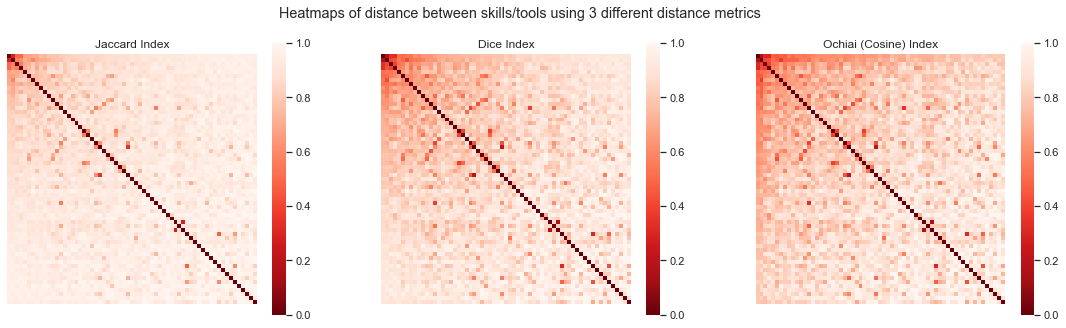

In [22]:
# create heatmaps of distance matrices created using the jaccard, dice & cosine (ochiai) indexes
fig, ax = plt.subplots(1,3, figsize=(19,5))

# create a distance matrix of skills/tools based on jaccard distance 
jaccardVector_st = distance.pdist(X, metric='jaccard')
# make the matrix square
jaccardMatrix_st = distance.squareform(jaccardVector_st)
# plot the distance matrix as a heatmap
sns.heatmap(ax=ax[0], data=jaccardMatrix_st, annot=False, vmin=0, vmax=1, cmap='Reds_r', cbar=True, 
    xticklabels=False, yticklabels=False, square=True
)

# create a distance matrix of skills/tools based on dice distance 
diceVector_st = distance.pdist(X, metric='dice')
# make the matrix square
diceMatrix_st = distance.squareform(diceVector_st)
# plot the distance matrix as a heatmap
sns.heatmap(ax=ax[1], data=diceMatrix_st, annot=False, vmin=0, vmax=1, cmap='Reds_r', cbar=True, 
xticklabels=False, yticklabels=False, square=True
)

# create a distance matrix of skills/tools based on ochiai (cosine) distance 
ochiaiVector_st = distance.pdist(X, metric='cosine')
# make the matrix square
ochiaiMatrix_st = distance.squareform(ochiaiVector_st)
# plot the distance matrix as a heatmap
sns.heatmap(ax=ax[2], data=ochiaiMatrix_st, annot=False, vmin=0, vmax=1, cmap='Reds_r', cbar=True, 
    xticklabels=False, yticklabels=False, square=True
)

fig.suptitle('Heatmaps of distance between skills/tools using 3 different distance metrics')
ax[0].set_title('Jaccard Index')
ax[1].set_title('Dice Index')
ax[2].set_title('Ochiai (Cosine) Index')


plt.show()

The heatmaps indicate that Dice and Ochiai distances vary more than Jaccard distances between the skills/tools in the jobs dataset. I'll use box plots to compare the distribution of the distances using the 3 metrics to confirm this.

Since the skills/tools in the distance matrix are in descending order or prevalence among job descriptions, the heatmaps also suggest that pairs of commonly mentioned skills/tools tend to have a smaller distance, while pairs of rarely mentioned skills/tools have higher distances.

In [23]:
# create a df to store the jaccard, dice and ochiai distances between skills/tools 
pairwise_dist = pd.DataFrame({
    'Jaccard': pd.Series(jaccardVector_st), 
    'Dice': pd.Series(diceVector_st),
    'Ochiai' : pd.Series(ochiaiVector_st),
})

# melt the data frame to ease plotting the distributions as boxplots 
pairwise_dist_melted = pd.melt(pairwise_dist)
pairwise_dist_melted.rename(columns = {'variable':'Distance Metric', 'value':'Distance'}, inplace = True)
pairwise_dist_melted.head()

,Distance Metric,Distance
0,Jaccard,0.280624
1,Jaccard,0.494305
2,Jaccard,0.490566
3,Jaccard,0.678492
4,Jaccard,0.672055


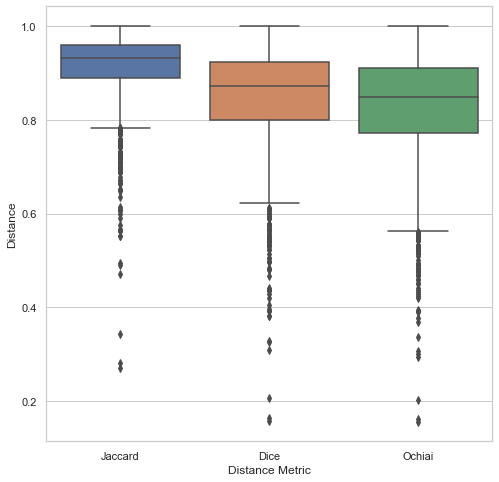

In [24]:
# plot boxplots of the jaccard, dice and ochiai distances between skills/tools 
plt.figure(figsize=(8, 8))
ax = sns.boxplot(x="Distance Metric", y="Distance", data=pairwise_dist_melted)

The box plots of the Jaccard, Dice and Ochiai distances between skills/tools suggest the same as what we can see in the heatmaps: the Dice and Ochiai distances between skills/tools vary more than the Jaccard distances. 

**Is this difference significant? The two-sample Kolmogorov-Smirnov test is used to test whether two samples come from the same cumulative distribution. I'll use it to do pairwise comparisons of the Jaccard, Dice and Ochiai distance distributions.**

The null hypothesis in the two-sample Kolmogorov-Smirnov test is that both groups are sampled from populations with identical distributions. It tests for any violation of that null hypothesis -- different medians, different variances, or different distributions.

The KS test tells you the maximum difference between the two cumulative distributions, and calculates a p-value from that and the sample sizes. I choose the standard confidence level of 95%: I will reject the null hypothesis that distributions are the same if the p-value is less than 0.05.

In [25]:
# two-sample Kolmogorov-Smirnov test to compare Jaccard, Dice and Ochiai distance distributions
print(f"Jaccard vs. Dice: {stats.ks_2samp(jaccardVector_st, diceVector_st)}\n")
print(f"Dice vs. Ochiai: {stats.ks_2samp(diceVector_st, ochiaiVector_st)}\n")
print(f"Jaccard vs. Ochiai: {stats.ks_2samp(jaccardVector_st, ochiaiVector_st)}\n")

Jaccard vs. Dice: KstestResult(statistic=0.34613415258576546, pvalue=3.7711347930698564e-104)

Dice vs. Ochiai: KstestResult(statistic=0.10957501280081926, pvalue=1.2571320292103136e-10)

Jaccard vs. Ochiai: KstestResult(statistic=0.42242703533026116, pvalue=1.3609268578295346e-156)



The p-value resulting from the pairwise two-sample Kolmogorov-Smirnov tests between the Jaccard, Dice and Ochiai distance distributions are all much smaller than 0.05, indicating that the distributions are significantly different in either their median, variability or shape.

The heatmaps of the distance matrixes using Jaccard, Dice and Ochiai, and the analysis of their distributions indicate that:
- there is very little variation in the Jaccard distances between skills/tools,

- the Dice distance matrix has more variation than the jaccard distance matrix,

- the Ochiai distances between skills/tools pairs vary the most (out of the 3 metrics)

- the variation in the Dice and Ochiai distance matrixes correlates with the frequency of the skills/tools: pairs of commonly mentioned skills/tools tend to have a smaller Dice/Ochiai distance, while pairs of rarely mentioned skills/tools have higher Dice/Ochiai distances. This is consistent with what we'd expect: if two skills/tools are popular among data science jobs, they are more likely to be mentioned together, and vice versa.

#### Summary: using a distance metric to measure strength of association between skills/tools

Since my data are asymmetric and our variables/set (the skills/tools) are not all equally saturated (some are common, most are rare) the ideal distance metric should either exclude joint absences or give positive matches more weight than negative matches, and should adjust for the base number of skills/tools present in the job descriptions being compared.

Having compared how Jaccard, Dice and Ochiai/Cosine are calculated, how they respond to changes in matches, differences, and saturation of attributes using dummy data, and the distribution of these 3 types of distances between the data science skills/tools, I conclude that:

**The Ochiai index is best suited to our data because:**

- **Joint absences are excluded**

- **It is sensitive to changes in both the number of matches and differences**

- **It accounts for sets that have a different saturation of attributes**

- **It results in more variation in distances between the skills/tools**

### Phi correlation (statistical metric) vs Ochiai similarity (distance metric)

Now I want to check whether Ochiai distance addresses some of the issues we identified with the statistical metric, Phi. 


To do that, I first need to make them comparable. The Phi correlation coefficient is on a scale from -1 to 1, with 1 meaning complete positive correlation, 0 meaning no relationship and -1 meaning complete negative correlation. Ochiai distance is on a scale from 1 to 1, where 0 means complete identity and 1 means no similarity. To put them on the same scale, I'll switch the Ochiai matrix from distance to similarity (1-distance), and put Phi on the same scale as Ochiai (0 to 1, with 1 meaning 100% match).

In [26]:
# switch Ochiai matrix from distance to similarity
ochiaisimMatrix_st = 1-ochiaiMatrix_st
ochiaisimMatrix_st

array([[1.        , 0.83899783, 0.69423152, ..., 0.19693028, 0.20263959,
        0.20263959],
       [0.83899783, 1.        , 0.6053165 , ..., 0.22423053, 0.16663928,
        0.2179129 ],
       [0.69423152, 0.6053165 , 1.        , ..., 0.10498163, 0.23148258,
        0.23148258],
       ...,
       [0.19693028, 0.22423053, 0.10498163, ..., 1.        , 0.11433239,
        0.        ],
       [0.20263959, 0.16663928, 0.23148258, ..., 0.11433239, 1.        ,
        0.11764706],
       [0.20263959, 0.2179129 , 0.23148258, ..., 0.        , 0.11764706,
        1.        ]])

In [27]:
# ensure the diagonal values are 1 (100% correlation)
np.fill_diagonal(phiMatrix_st,1)

# put phi correlation coefficients on the same scale as ochiai (so that min and max values are 0 and 1)
phi_rescaled = (phiMatrix_st - np.min(phiMatrix_st)) / (np.max(phiMatrix_st) - np.min(phiMatrix_st))
phi_rescaled


array([[1.        , 0.45762712, 0.33898305, ..., 0.21186441, 0.22881356,
        0.22881356],
       [0.45762712, 1.        , 0.20338983, ..., 0.25423729, 0.1779661 ,
        0.25423729],
       [0.33898305, 0.20338983, 1.        , ..., 0.11864407, 0.27966102,
        0.27966102],
       ...,
       [0.21186441, 0.25423729, 0.11864407, ..., 1.        , 0.22033898,
        0.11864407],
       [0.22881356, 0.1779661 , 0.27966102, ..., 0.22033898, 1.        ,
        0.22881356],
       [0.22881356, 0.25423729, 0.27966102, ..., 0.11864407, 0.22881356,
        1.        ]])

In [28]:
# rescale ochiai similarity matrix (so that min and max values are 0 and 1)
ochiai_rescaled = (ochiaisimMatrix_st - np.min(ochiaisimMatrix_st)) / (np.max(ochiaisimMatrix_st) - np.min(ochiaisimMatrix_st))
ochiai_rescaled

array([[1.        , 0.83899783, 0.69423152, ..., 0.19693028, 0.20263959,
        0.20263959],
       [0.83899783, 1.        , 0.6053165 , ..., 0.22423053, 0.16663928,
        0.2179129 ],
       [0.69423152, 0.6053165 , 1.        , ..., 0.10498163, 0.23148258,
        0.23148258],
       ...,
       [0.19693028, 0.22423053, 0.10498163, ..., 1.        , 0.11433239,
        0.        ],
       [0.20263959, 0.16663928, 0.23148258, ..., 0.11433239, 1.        ,
        0.11764706],
       [0.20263959, 0.2179129 , 0.23148258, ..., 0.        , 0.11764706,
        1.        ]])

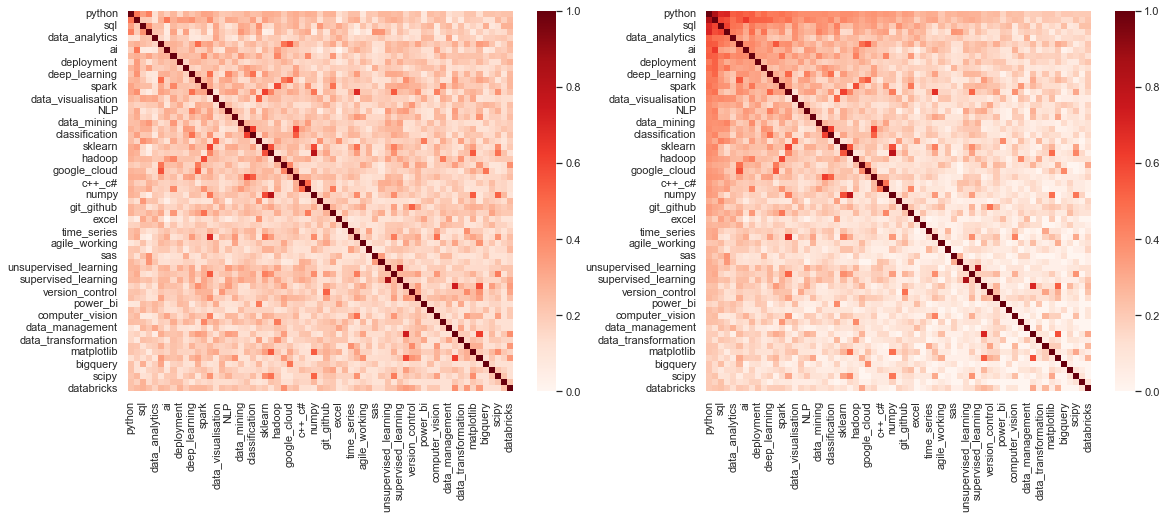

In [29]:
# turn the rescaled phi correlation and ochiai similarity matrixes into DataFrames for heatmaps
phirescaledMatrix_st = pd.DataFrame(phi_rescaled, index=ds_bothst.columns, columns=ds_bothst.columns)
ochiairescaledMatrix_st = pd.DataFrame(ochiai_rescaled, index=ds_bothst.columns, columns=ds_bothst.columns)

# plot heatmaps of rescaled phi correlation and ochiai similarity matrixes
fig, ax = plt.subplots(1,2, figsize=(19,7))
sns.heatmap(
    phirescaledMatrix_st, 
    annot=False,
    cmap='Reds',
    ax=ax[0]
    )

sns.heatmap(
    ochiairescaledMatrix_st, 
    annot=False,
    cmap='Reds',
    ax=ax[1]
    )
plt.show()


The Phi correlation matrix doesn't indicate any relationship with how common the skills/tools are; while the Ochiai similarity matrix indicates that common skills/tools are more often found together, which is what you'd expect by chance. 

Before I compare Phi and Ochiai similarity values, I'll compare their distributions usig box plots

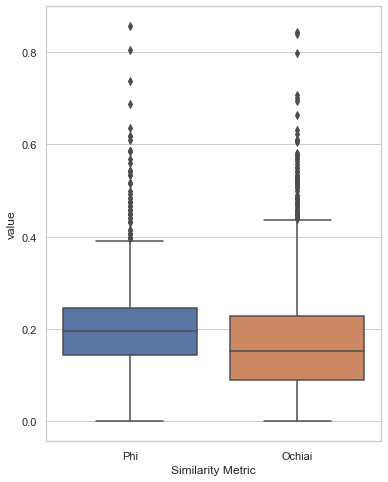

In [30]:
# switch the diagonal values from 1 to 0 for compatability with distance.squareform
np.fill_diagonal(phi_rescaled,0)
np.fill_diagonal(ochiai_rescaled,0)

# force the square phi_rescaled into a vector
phirescaledVector_st = distance.squareform(phi_rescaled, force='tovector')
ochrescaledVector_st = distance.squareform(ochiai_rescaled, force='tovector')

# create a df to store the phi and ochiai similarities between skills/tools 
phi_v_och = pd.DataFrame({
    'Phi': pd.Series(phirescaledVector_st), 
    'Ochiai' : pd.Series(ochrescaledVector_st),
})

# melt the data frame to ease plotting the distributions as boxplots 
phi_v_och_melted = pd.melt(phi_v_och)
phi_v_och_melted.rename(columns = {'variable':'Similarity Metric'}, inplace = True)
phi_v_och_melted.head()

# plot boxplots of the phi and ochiai distances between skills/tools 
plt.figure(figsize=(6, 8))
ax = sns.boxplot(x='Similarity Metric', y="value", data=phi_v_och_melted)

Taking the examples of skill/tool pairs I checked to see how well Phi was working for the data, I'll now compare the Phi correlation with the Ochiai similarity, to see if Ochiai suits the skills/tool text analysis data better than Phi.

*** Python vs Machine Learning ***

Jobs mentioning Python: 81.0%
Jobs mentioning Machine Learning: 70.1%

Contingency table:


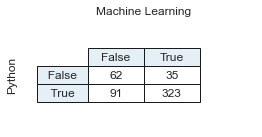

Phi: 0.458
Ochiai: 0.839


In [31]:
# high frequency, very many more matches than mismatches
correlatebinvar(ds_bothst, 'python', 'machine_learning', plot=False)

print(f"Phi: {np.round_(phirescaledMatrix_st.loc['python','machine_learning'], decimals=3)}")
print(f"Ochiai: {np.round_(ochiairescaledMatrix_st.loc['python','machine_learning'], decimals=3)}")


*** Python vs Machine Learning *** : There is roughly a 3:1 ratio of jobs mentioning both python and ML to jobs mentioning just one or the other, resulting in an Ochiai similarity that indicates a very strong relationship, while the Phi coefficient suggests just a moderate positive relationship, because when compared to the number of jobs mentioning neither, the proportion of jobs mentioning just one or the other is relatively high. The more the data falls off the diagonal, the higher Phi is. The Ochiai similarity seems more appropriate here, because our data are asymmetric: negative matches are not as informative as positive matches and mismatches, and in this case, the majority of jobs mention both python and machine learning, which we would deem a strong correlation. 

*** Supervised Learning vs Unsupervised Learning ***

Jobs mentioning Supervised Learning: 6.1%
Jobs mentioning Unsupervised Learning: 6.5%

Contingency table:


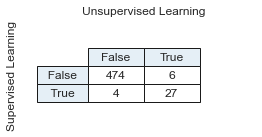

Phi: 0.856
Ochiai: 0.844


In [32]:
# low frequency, many more matches than mismatches
correlatebinvar(ds_bothst, 'supervised_learning', 'unsupervised_learning', plot=False)

print(f"Phi: {np.round_(phirescaledMatrix_st.loc['supervised_learning','unsupervised_learning'], decimals=3)}")
print(f"Ochiai: {np.round_(ochiairescaledMatrix_st.loc['supervised_learning','unsupervised_learning'], decimals=3)}")


*** Supervised Learning vs Unsupervised Learning ***: Both Phi and Ochiai indicate a very strong relationship between these two: Phi is high because of the very high proportion of jobs that mention neither and very few mention just one or the other; Ochiai is high because there is a 3:1 ratio of jobs mentioning both supervised and unsupervised learning to jobs mentioning just one or the other. Since they are almost always mentioned together when they are mentioned, we would consider supervised and unsupervised learning to be strongly correlated; the Phi coefficient suggests this, but for the "wrong" reason. 

*** R vs Artifical Intelligence ***

Jobs mentioning R: 44.2%
Jobs mentioning Artifical Intelligence: 30.9%

Contingency table:


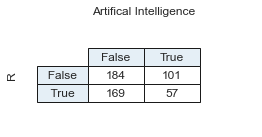

Phi: 0.059
Ochiai: 0.302


In [33]:
# high freq, many fewer matches than mismatches
correlatebinvar(ds_bothst, 'r', 'ai', plot=False)

print(f"Phi: {np.round_(phirescaledMatrix_st.loc['r','ai'], decimals=3)}")
print(f"Ochiai: {np.round_(ochiairescaledMatrix_st.loc['r','ai'], decimals=3)}")


*** R vs Artifical Intelligence ***: Both Phi and Ochiai indicate a weak correlation. The Phi correlation is lower because most of the data falls off the diagonal, i.e. more jobs mention one or the other than both or neither. The Ochiai similarity is higher because it doesn't factor in the joint absenses and it doesn't pool the attributes: it factors in the difference in the saturation of attributes (in this case, the fact that more than a third of jobs mentioning AI also mention r).

*** Linux vs BigQuery ***

Jobs mentioning Linux: 3.5%
Jobs mentioning BigQuery: 3.5%

Contingency table:


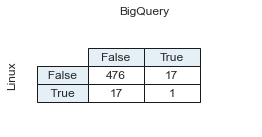

Phi: 0.169
Ochiai: 0.056


In [34]:
# low freq, many fewer matches than mismatches
correlatebinvar(ds_bothst, 'linux', 'bigquery', plot=False)

print(f"Phi: {np.round_(phirescaledMatrix_st.loc['linux','bigquery'], decimals=3)}")
print(f"Ochiai: {np.round_(ochiairescaledMatrix_st.loc['linux','bigquery'], decimals=3)}")


*** Linux vs BigQuery ***: Only 1 in more than 500 jobs mentions these together so both Phi and Ochiai are low, but the hundreds of jobs that mention neither means that Phi correlation is a bit higher than Ochiai similarity, which doesn't factor in negative matches. Since negative matches are not informative in our case, the Ochiai similarity is more appropriate here.

**Having compared Phi and Ochiai, I'm happy that using Ochiai proximity is the best way to identify the strength of correlation between skills and tools, and to identify groups of related skills/tools using clustering**

## Clustering

Clustering is an unsupervised machine learning technique that groups data points that have similar properties and/or features. I might be able to use clustering to group related skills/tools.

#### Which Clustering Algorithm?

Many clustering algorithms (such as Density-Based Spatial Clustering of Applications with Noise [DBSCAN], K-Means, Mean-Shift Clustering) use the distance between points in 2 or more dimensions as a measure of their similarity and use this to identify groups based on the points that are the closest to one another. This means that the most commonly used clustering algorithms perform best with continuous variables/features. 

If you have categorical data (e.g. if you one-hot encode attributes as I have done in this project), your points occupy a discrete number of positions in space, separated from one another by a discrete number of distances. You can use a clustering algorithm for categorical data, in which you must specify how many clusters you expect there to be in your data (e.g. K-Modes). Unless your data has just 2 or 3 dimensions, it is not possible to visually understand the clusters present in the data; my data has as many dimensions as there are skills/tools! Without visual cues, you need some knowledge of the data and some amount of heuristics to decide which number of clusters produces a sensible-looking result: which number of clusters produces clusters that look right for the parts of the data that you know (which we can then assume must also be vaguely sensible for the parts that you don't know about).

The **Agglomerative Hierarchical clustering** algorithm might work well for my data: at first, a distance matrix is created for all attributes, and each one is considered to be an individual cluster. At each iteration, the two most similar clusters are merged together and the distance matrix updated, until just one cluster encompassing all data points is formed. The result is presented visually in the form of a dendrogram, which shows the sequence of merges, and it is from this diagram that you may be able to identify different groups. No matter the data, this algorithm remains the same, but what needs to be considered carefully is the way in which the proximity matrix is calculated. 

#### Hierarchical clustering: which linkage method?

It is not always appropriate to cluster binary data: since there are only 2 possible values that each binary variable can take (0 or 1), there is the potential to have a high number of ties in distance that would make the resulting clusters dependant on the ordering of the attributes in the distance matrix. In my data there are 63 attributes; the high number of variables will reduce the frequency of ties. 

In order to cluster the skills/tools, I first need to choose how the similarity between clusters will be calculated. There are 5 main ways of doing this, which I will explain in terms of two clusters, $X$ and $Y$:

- **Single-Linkage**: 

    Calculate the pairwise distances between every element in one cluster and every element in the other cluster, and declare the shortest pairwise distance to be the similarity between $X$ and $Y$:

    $$D(X,Y) = \min_{x \in X, \ y \in Y}\ d(x,y),$$

    where $X$ and $Y$ are any two sets of elements considered as clusters, and $d(x,y)$ denotes      the distance between the two elements $x$ and $y$.

    Single-Linkage can separate non-elliptical shapes, but it struggles to create distinct clusters when there is a lot of noise. It has a tendancy to produce long chains (loose, less spherical clusters).

$ $
$ $

- **Complete-Linkage**: 

    This is the exact opposite of the Single-Linkage Algorithm, i.e. it declares the **longest** of pairwise distances between elements in $X$ and $Y$ as       the distance between the clusters:

    $$D(X,Y) = \max_{x \in X, \ y \in Y}\ d(x,y),$$
    
    where $X$ and $Y$ are any two sets of elements considered as clusters, and $d(x,y)$ denotes the distance between the two elements $x$ and $y$.
    
    Using complete linkage to find the two clusters that are the closest to one another is equivalent to choosing the cluster pair whose merge has the smallest diameter, so it is biased towards globular, compact clusters with small diameters, which can end up very close together. Although this method works better to create clusters when they are noisy, it can also break up large clusters due to noise.

$ $
$ $

- **Average-Linkage**: 

    As the name implies, this algorithm declares the average pairwise distance between elements in X and Y as the distance between the clusters.
    
    $$D(X,Y) = \frac{\sum d(x,y)}{|X|*|Y|},$$
    
    where $|X|$ and $|Y|$ denote the sum of elements in clusters $X$ and $Y$, respectively, and $d(x,y)$ denotes the distance between the two elements $x$ and $y$.
    
    This algorithm is good at separating clusters that have noise between them because it is less sensitive to outliers, but it is biased towards globular structures.

$ $
$ $

- **Centroid Linkage (A.K.A. Unweighted Pair Group Method using Centroids)**: 

    The distance between the two clusters is the distance between the mean vector location of each cluster, i.e. the distance between the centroids of the     clusters.
    
    $$D(X,Y) = d(\overline x, \ \overline y),$$
    
    where $X$ and $Y$ are any two sets of elements considered as clusters, and $d(x,y)$ denotes the distance between the two elements $x$ and $y$.
    
    Centroid linkage is less sensitive to outliers than single and complete linkage, but it is biased towards globular clusters, and
    can cause inversions ([reference](https://www.uio.no/studier/emner/matnat/ifi/nedlagte-emner/INF4820/h12/undervisningsmateriale/06_clustering.pdf)):        when two separate clusters somewhere in their hierarchy are combined with a distance that is smaller (lower) in the hierarchy than where the original       clusters were formed. The reason for this is that, as the centroids change when a new merge is made, it is possible that the smaller clusters are more      similar to the new larger cluster than to the individual clusters that were marged to make it. This doesn't happen with the other linkage methods,          where the clusters being merged will always be more similar to themselves than to the new larger cluster.

$ $
$ $

- **Ward's Method (Minimum Variance Method)**:

    The distance between the two clusters is how much the sum of squares (variance) will increase when we merge them, which the Ward's method tries to keep as small as possible. At each step, to decide which two clusters should be merged, the variance of each possible combination must be calculated to find the smallest one, and this is done as follows ([reference](https://www.statisticshowto.com/wards-method/)):

    1. Find the mean of each cluster.
    2. Calculate the distance between each object in a particular cluster, and that cluster’s mean.
    3. Square the differences from Step 2.
    4. Sum the squared values from Step 3.
    5. Add up all the sums of squares from Step 4.

    $$D(X,Y) = \frac{\sum d(x,y)^{2}}{|X|*|Y|},$$

    Ward's method is also less sensitive to outliers than single and complete linkage, but it is also biased towards globular structures and does not cause inversion. 


So which of these is the most appropriate for my data? All of the clustering methods described above are designed to identify clusters based on euclidean distances and are therefore best-suited to continuous variables, not binary ones; the Centroid and Ward's methods cannot be used with binary data at all because they logically require (squared) euclidean distance to compute centroids in euclidean space. It would be inappropriate to compute geometric centroids from binary data (which doesn't form globular structures in multi-dimensional space), using a non-euclidiean distance measure. Of the Single, Complete and Average Linkage methods, the Average Linkage method is the best because it factors all elements into the computation, giving more balanced clusters.

In [35]:
# Create a linkage matrix (Z) of the skills and tools based on their distances from one another, 
# i.e. cluster the skills and tools, using the Average method
Z = hierarchy.linkage(ochiaiVector_st, method='average')

# Print the shape of the Z to check that it's what we'd expect
Z.shape

(62, 4)

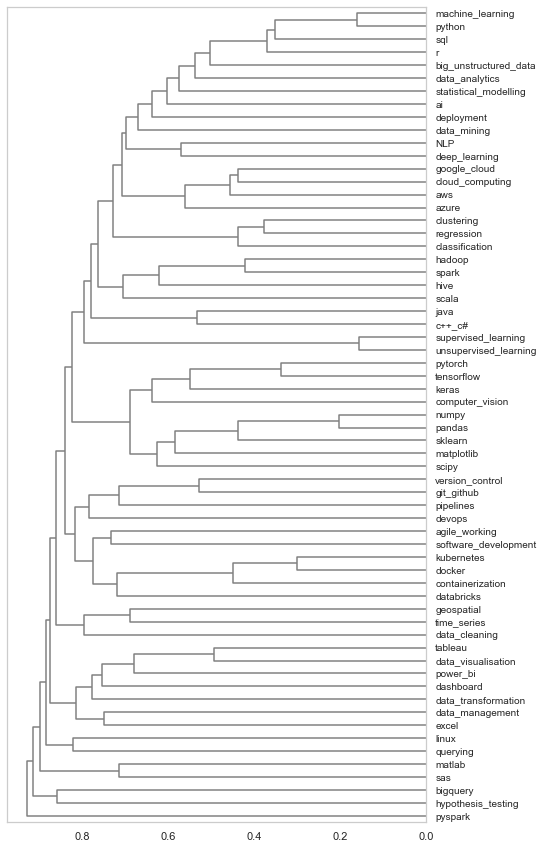

In [36]:
fig, ax = plt.subplots(1,1, figsize=(7.5,15))

# for idx in X.index:
#     X.rename(index={idx:dict_both_st[idx]['label']}, inplace=True)

dn = hierarchy.dendrogram(
    Z, 
    orientation='left', 
    labels = list(X.index), 
    leaf_font_size = 10, 
    color_threshold=0, 
    above_threshold_color='grey'
)

ax.grid(False)
plt.show()

**How do we find the number of clusters?**

If you have a good understanding of your data you might know how many clusters you are looking for, allowing you to specifiy the maximum number of clusters, but this is the not the case with my data set. I do not have an idea of how many groups of data science skills/tools I expect to find. 

In a dendrogram, the data set may naturally align into clusters: groups of objects densely packed in certain areas and not in others. `scipy.cluster.hierarchy.dendrogram` colours all the descendent links below a cluster node the same colour if the cluster node is the first one below the cut threshold (`color_threshold`, `t`). All links connecting nodes with distances greater than or equal to the threshold are colored the same. Note that in the dendrogram above, `t` has been set to 0, so there are no coloured links.

Where should the threshold be? There is no definitive answer to this question because unsupervised clustering is an exploratory tool. The interpretation of any dendrogram is context-dependent and there can be several solutions that are equally adequate in theory. 


The SciPy hierarchical clustering module documentation indicates that many of the functions are based on equivant MATLAB functions. The MATLAB documentation on hierarchical clustering tutorial (http://mathworks.com/help/stats/hierarchical-clustering.html) discusses how to investigate natural divisions that exist among links between objects in the dendrogram. 

One way to determine these natural divisions is by comparing the height of each merge in the tree with the heights of neighboring merges below it. Merges at a similar height to those below them suggest no distinct divisions between the objects joined at this level of the hierarchy (i.e. the merges exhibit a high level of consistency). But if there is a merge at a height that is noticeably different from the height of the merges below it, this suggests that the objects joined at this level in the hierarchy are more dissimilar to one another than their components were when they were combined (i.e. this merge can be considered inconsistent with the merges below it). But how do you define a merge that is inconsistent? 



I will try to use the `scipy.cluster.hierarchy.inconsistent` method to set a threshold for the clustering. For every link in the linkage matrix, `inconsistent` calculates the mean and standard deviation of the heights of the links *d* levels below (*d*=2 by default) and uses these to create an inconsistency coefficient by subtracting the mean and dividing by the standard deviation. For links that have no further links below them, the inconsistency coefficient is set to 0.


In [37]:
from scipy.cluster.hierarchy import inconsistent
# create an inconsistency coefficient matrix (Z_inc) from the linkage matrix (Z)
Z_inc = inconsistent(Z)
# print the frequencies of the inconsisteny coefficients
Z_inc_df = pd.DataFrame(Z_inc, columns=['mean','std','n_links','inc'])
Z_inc_df['inc'].value_counts().sort_index(ascending=True)


0.000000    18
0.601163     1
0.631290     1
0.640442     1
0.640458     1
0.640689     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.707107     1
0.708236     1
0.758772     1
0.762448     1
0.775254     1
0.843746     1
0.862036     1
1.043307     1
1.056674     1
1.103339     1
1.118782     1
1.130063     1
1.134979     1
Name: inc, dtype: int64

Most of the inconsistency coefficients are either zero (because for links that have no further links below them, the inconsistency coefficient is set to 0) or 0.707107. The .value_counts() method lists every instance of 0.707107 as a separate value; this is likely because .value_counts() rounds floating-point numbers to 6 decimal places and the full number is subtly different due to rounding errors in the calculation of the inconsistent coefficient. Because floats have a limited number of digits, they cannot represent all real numbers accurately: when there are more digits than the format allows, the leftover ones are omitted - the number is rounded. In reality these are all the same number. To understand why so many have the exact same inconsistency coefficient of 0.707107 I'll look at the properties of the links that have this value.

In [38]:
# create a dataframe of Z and Z_inc to analyse why so many links have an inconsistency coefficient of 0.707107
Z_df = pd.DataFrame(data=Z, columns=['cluster_1','cluster_2','distance','n_obs'])
Z_all = pd.concat([Z_df, Z_inc_df], axis=1)
# change the index so that it matches the index of links used in columns cluster_1 and cluster_2
Z_all.index += 63 
# round 'inc' to 6 decimal places to remove differences in rounding of the value 0.707107
Z_all['inc'] = Z_all['inc'].round(6)
Z_all.head(10)

,cluster_1,cluster_2,distance,n_obs,mean,std,n_links,inc
63,42.0,44.0,0.155838,2.0,0.155838,0.000000,1.0,0.000000
64,0.0,1.0,0.161002,2.0,0.161002,0.000000,1.0,0.000000
65,23.0,30.0,0.202618,2.0,0.202618,0.000000,1.0,0.000000
66,45.0,53.0,0.299351,2.0,0.299351,0.000000,1.0,0.000000
67,13.0,37.0,0.336086,2.0,0.336086,0.000000,1.0,0.000000
68,2.0,64.0,0.350226,3.0,0.255614,0.133801,2.0,0.707107
69,3.0,68.0,0.369267,4.0,0.359746,0.013464,2.0,0.707107
70,19.0,27.0,0.377095,2.0,0.377095,0.000000,1.0,0.000000
71,12.0,24.0,0.419729,2.0,0.419729,0.000000,1.0,0.000000
72,5.0,26.0,0.436306,2.0,0.436306,0.000000,1.0,0.000000


In [39]:
Z_all[Z_all['inc']==0.707107]

,cluster_1,cluster_2,distance,n_obs,mean,std,n_links,inc
68,2.0,64.0,0.350226,3.0,0.255614,0.133801,2.0,0.707107
69,3.0,68.0,0.369267,4.0,0.359746,0.013464,2.0,0.707107
73,20.0,70.0,0.436339,3.0,0.406717,0.041891,2.0,0.707107
74,22.0,65.0,0.437113,3.0,0.319866,0.165813,2.0,0.707107
75,57.0,66.0,0.448600,3.0,0.373975,0.105535,2.0,0.707107
76,11.0,72.0,0.455349,3.0,0.445827,0.013465,2.0,0.707107
78,7.0,69.0,0.501157,5.0,0.435212,0.093261,2.0,0.707107
81,4.0,78.0,0.537689,6.0,0.519423,0.025832,2.0,0.707107
82,43.0,67.0,0.548466,3.0,0.442276,0.150175,2.0,0.707107
83,25.0,76.0,0.559895,4.0,0.507622,0.073926,2.0,0.707107


All links that have an inconsistency cofficient of 0.707107 have one thing in common: they are made up of exactly 2 links. I suspected that when *d* is 2, the inconsistency coefficient equation must always give the same value. By refactoring the equation, I confirmed that this is true: the result is always $1/\sqrt{2}$ = 0.70710678118

Since most of the links have this inconsistency coefficient, I'll us it as the threshold for identifying clusters: links with an inconsistency coefficient lower than than 0.70710678118 will be considered part of the cluster and vice versa


It seems that in the case of my hierarchical clustering of skills and tools, it would be difficult to apply the `inconsistent` method to identify clusters, so I will make some observations based on the default threshold (`t` = 0.7) used by the `dendrogram` method instead. 

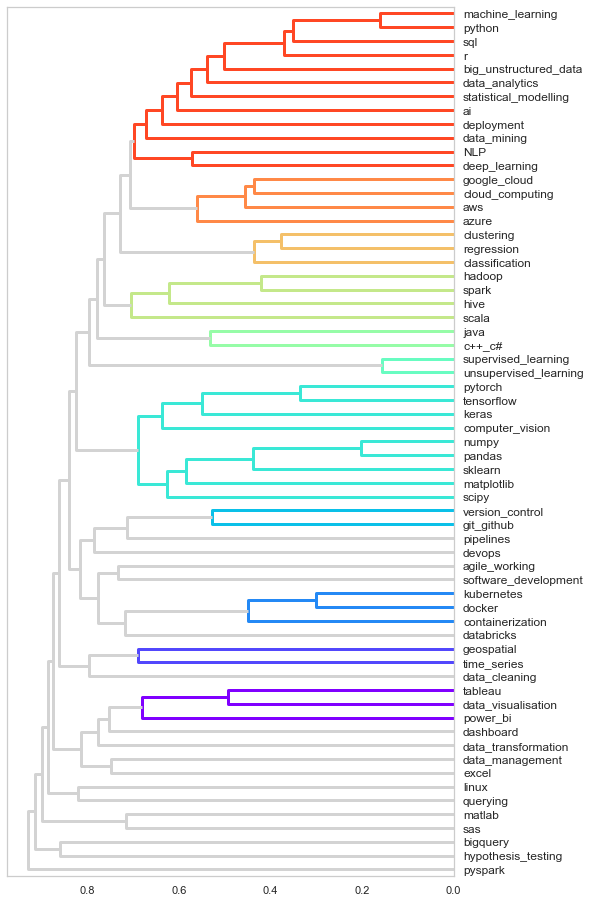

In [40]:
fig, ax = plt.subplots(1,1, figsize=(8,16))

cmap = cm.rainbow(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Override the default linewidth.
plt.rcParams['lines.linewidth'] = 3

dn = hierarchy.dendrogram(
    Z, 
    orientation='left', 
    labels = list(X.index), 
    leaf_font_size = 12,
    color_threshold=0.707107,
    above_threshold_color='lightgrey',   
)

ax.grid(False)
plt.savefig("./images/pt5_dendrogram.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

The clusters created by setting the inconsistent threshold to 0.707107 look reasonable:

1. **Machine Learning, python, SQL, R, big unstructured data, data analytics, statistical modelling, AI, deployment, data mining, NLP, Deep Learning**: Although many of the things in this first cluster are known to be related (e.g. big unstructured data and data analytics, statistical modelling and AI, NLP and deep learning), this first and largest cluster also represents the most common skills and tools mentioned in Data Scientist role descriptions. Common skills and tools are more likely to be mentioned together by chance.  

2. **Cloud computing Google Cloud, AWS, and MicroSoft Azure**: This cluster makes perfect sense because cloud computing is the skill and the other 3 are all cloud computing platforms/services

3. **Clustering, regression and classification**: These are all types of machine learning taks/problems. 

4. **Hadoop, Spark, Hive, Scala**: Hadoops, Spark and Hive (all by Apache) are open-source big data processing and analysis technologies; Scala is a general purpose programming language, but is often used with Hadoop and Spark because it allows you to do a lot of thing parallel, which is important for big data.

5. **Java, C++, C#**: Common general purpose object-oriented programming languages, often used in large-scale production software projects.

6. **Supervised and unsupervised learning**: These described how machine learning algorithms are applied; they are not mentioned often, but almost always mentioned together. Supervised learning uses labeled data to train or “supervise” algorithms into classifying data or predicting outcomes accurately. Unsupervised learning uses algorithms to discover hidden patterns or clusters in data without the need for human input.

7. **Computer vision PyTorch, TensorFlow, Keras, Numpy, Pandas, sklearn, matplotlib, scipy**: These have been identified as one cluster, and while all the tools in this group are python packages, they look like they could have been split into 2 separate clusters if the threshold was slightly different: 
> - PyTorch, TensorFlow, Keras, and computer vision: Computer vision requires deep learning, and PyTorch, TensorFlow and Keras are all tools used for deep learning.
> - Numpy, Pandas, sklearn, matplotlib, scipy: commonly used python data analysis, machine learning and data visualisation software

8. **Version control and Git/Github**: Git is tool for version control; it records different versions of a file (or set of files), and lets users access, compare, update, and distribute any of the recorded versions at any time. GitHub is mainly a hosting platform for Git repositories.

9. **Containerization, Kubernetes, and Docker**: Containerization is a method of packaging software with all its dependencies to run in minimal virtual environments called "containers", the most popular of which is Docker. Kubernetes is used to orchestrate the deployment of multiple containers deployed across multiple servers using an API that controls how and where those containers will run.

10. **Geo-spatial and time-series**: The pairing of geospatial and time-series data is common, so experience with analysing and making predictions based on both of these data types together is also common. 

11. **Data visualization, Tableau and PowerBI**: Tableau and PowerBI are two commonly used platforms/software for data analysis, manipulation, and visualization  for drawing insights from business data, i.e. business intelligence. Closely related but not included in the cluster is dashboards, which is a data visualization and analysis tool that displays, on one screen, the status of key performance indicators and other metrics/data for an organization, department, team or process.


## Conclusions

- The results have given me a good idea of the most commonly mentioned skills and tools in job adds and how they relate to one another

- The data analysis, machine learning and data visualisation knowledge and skills that I have (numpy, pandas, sklearn, matplotlib, and scipy) are among the most commonly mentioned by employers

- The clustering results will help me to fill in the gaps in my knowledge and/or experience that employers are looking for
